In [51]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import json

from IPython.core.display import HTML, display

In [2]:
HTML("""<style>.container { width:100% !important; } div.output_area {overflow-y: scroll;} div.output_area img {max-width: unset;} </style>""") 

<i>Firstly, we shall retrive captions per each image</i>

In [28]:
with open('parameters.json') as json_file: data = json.load(json_file)
doc = open('data/Flickr8k.token.txt',"r").read()
params = {}

image_captions_original = {}
list_of_sentences = []

for capt in doc.split('\n'):
    
    try:
        image_name, content = capt.split('\t')
        image_name = image_name[:-2]
        sentence = ' startseq ' + content.split('.')[0] + ' endseq . '
        list_of_sentences.append(sentence)
        
        if image_name not in image_captions_original:
            image_captions_original[image_name] = []

        image_captions_original[image_name].append(sentence)
        
    except:
        pass

In [29]:
image_captions_original[list(image_captions_original.keys())[0]]

[' startseq A child in a pink dress is climbing up a set of stairs in an entry way  endseq . ',
 ' startseq A girl going into a wooden building  endseq . ',
 ' startseq A little girl climbing into a wooden playhouse  endseq . ',
 ' startseq A little girl climbing the stairs to her playhouse  endseq . ',
 ' startseq A little girl in a pink dress going into a wooden cabin  endseq . ']

#### Analyzing word frequencies

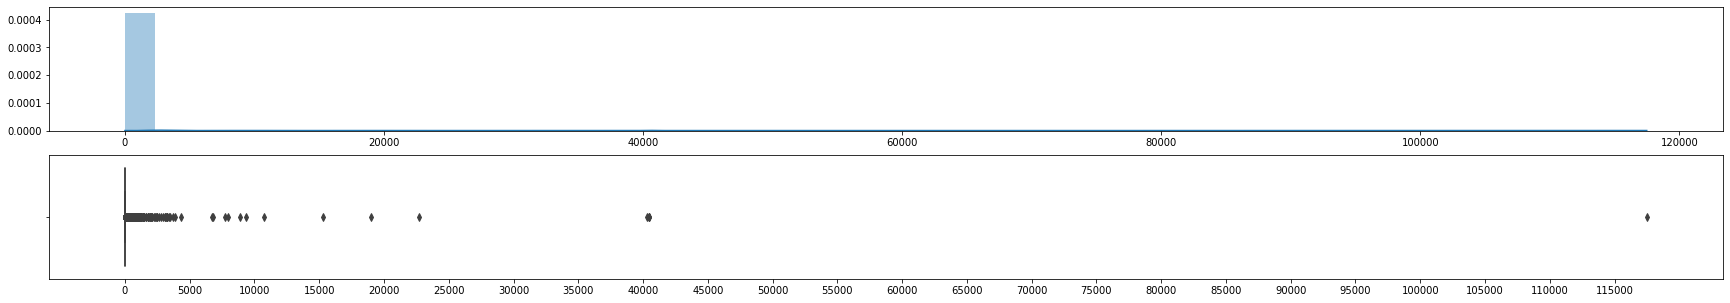

In [15]:
word_freq = {}

for sentence in list_of_sentences:
    for word in sentence.split(' '):
        if word not in word_freq:
            word_freq[word] = 0
        word_freq[word]+=1
        
fig, axs = plt.subplots(2,1, figsize=(30, 5) )
values = list(word_freq.values())
max_val = max(values)

_ = sns.distplot(values, ax=axs[0])
_ = sns.boxplot(values, ax=axs[1])
_ = plt.xticks(np.arange(0, max_val, 5000))

<i>As we can notice, most of the words appear with frequency below 5000. To obtain a more powerful model, it might be a better choice to focus on most important words, e.g. 1500 most frequent ones.</i>

In [30]:
params['NB_WORDS'] = 1500
params['EMB_DIM'] = 300

tk = Tokenizer(num_words=params['NB_WORDS'], filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
tk.fit_on_texts(list_of_sentences)
tk_sentences = tk.texts_to_sequences(list_of_sentences)

#### Sentence analysis

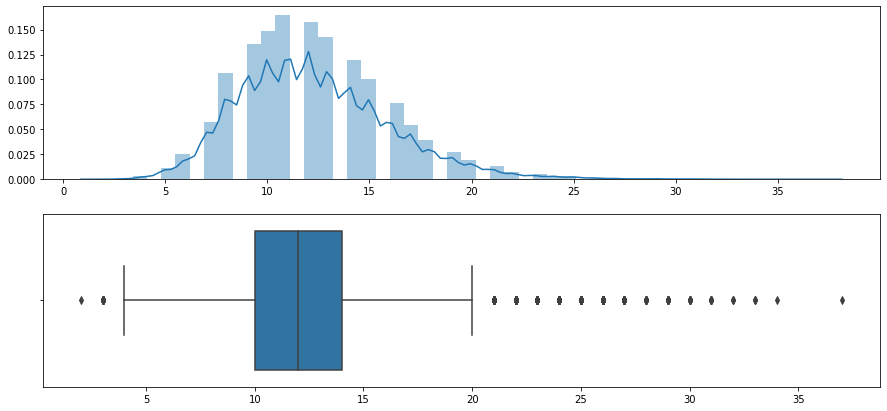

In [19]:
sent_len = [len(sen) for sen in tk_sentences]
max_val = max(sent_len)

fig, axs = plt.subplots(2,1, figsize=(15, 7) )
_ = sns.distplot(sent_len, ax=axs[0])
_ = sns.boxplot(sent_len, ax=axs[1])

<i>Most of the sentence lengths appear to be between 10 and 15. We will assign upper threshold to be 20 given its closest value to upper whisker in boxplot. In the following code we firstly assign to every image its padded tokenizer sentence values. Afterwards we generate an embedding matrix from fasttext vectors. </i>

In [33]:
params['MAX_LEN'] = 20
image_captions = {}

for img, sentences in image_captions_original.items():
    tk_sentences = tk.texts_to_sequences(sentences)
    image_captions[img] = pad_sequences(tk_sentences, maxlen=params['MAX_LEN'], padding='post')

In [35]:
embedding = {}
with open(data['embedding_path'], "r", encoding='utf8') as f:
    for i, line in enumerate(f.readlines()):
        s = line.split() 
        value = np.array([np.float16(x) for x in s[1:]])
        word = s[0]
        embedding[word] = value
        
emb_matrix = np.zeros((params['NB_WORDS'], params['EMB_DIM']))
set_words = set(embedding.keys())

for word, i in tk.word_index.items():
    if word not in set_words or i >= params['NB_WORDS']: continue
    else: emb_matrix[i] = np.float16(embedding[word]); 

In [40]:
pkl.dump( {'tk':tk,'image_captions':image_captions, 'emb_matrix':emb_matrix, 'params':params}, open( "pkl_files/caption_data.pkl", "wb" ) )

[Next step: Extracting image features](image_extraction.ipynb)